<a href="https://colab.research.google.com/github/vasudhavenkatesan/pix2pix/blob/main/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipdb

## Importing necessary libraries

In [12]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import torchvision
from torchvision.utils import make_grid
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.transforms import InterpolationMode

# Loading data

In [13]:
class MapDataset(Dataset):
  def __init__(self, root_dir):
    self.root_dir = root_dir
    self.list_files = os.listdir(self.root_dir)
    # print(self.list_files)
    self.data_transforms = transforms.Compose([
         transforms.ToPILImage(),
        transforms.Resize(size=(256,256), interpolation=InterpolationMode.NEAREST),
                                      transforms.CenterCrop(size=(256,256)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]) 

  def __len__(self):
    return len(self.list_files)

  def __getitem__(self, index):
    img_file = self.list_files[index]
    img_path = os.path.join(self.root_dir, img_file)
    image = np.array(Image.open(img_path))
    img_pil = Image.fromarray(image)
    input_image = image[:, :600, :]
    target_image = image[:, 600:, :]
    input_image = self.data_transforms(input_image)
    target_image = self.data_transforms(target_image)
    return input_image, target_image
    


In [10]:
from __main__ import MapDataset
data_dir = "/content/drive/MyDrive/maps_dataset/maps/"

dataset_train = MapDataset(root_dir=os.path.join(data_dir, "train"))
dataset_val = MapDataset(root_dir=os.path.join(data_dir, "val"))

dataloader_train = DataLoader(dataset=dataset_train, batch_size=24, shuffle=True, num_workers=2)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=24, shuffle=True, num_workers=2)

print(len(dataloader_train))


47


# Building Generator

In [5]:
#UNET

class DownSample(nn.Module):
  def __init__(self, input_channels = 3, output_channels = 3):
    super(DownSample, self).__init__()
    self.model = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size= 4, stride = 2, padding=1, bias =False),
                               nn.LeakyReLU(0.2))
  def forward(self, x):
    down = self.model(x)
    return down

class UpSample(nn.Module):
  def __init__(self, input_channels, output_channels):
    super(UpSample, self).__init__()
    self.model = nn.Sequential(nn.ConvTranspose2d(input_channels, output_channels, kernel_size=4, stride =2, padding =1, bias=False),
                               nn.InstanceNorm2d(output_channels),
                               nn.ReLU(inplace=True))
    
  def forward(self, x, skip_connection):
    up = self.model(x)
    up = torch.cat((up, skip_connection), 1)
    return up

class Generator(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(Generator, self).__init__()
    self.down1 = DownSample(in_channel, 64)
    self.down2 = DownSample(64, 128)
    self.down3 = DownSample(128, 256)
    self.down4 = DownSample(256, 512)
    self.down5 = DownSample(512, 512)
    self.down6 = DownSample(512, 512)
    self.down7 = DownSample(512, 512)
    self.down8 = DownSample(512, 512)

    self.up1 = UpSample(512, 512)
    self.up2 = UpSample(1024, 512)
    self.up3 = UpSample(1024, 512)
    self.up4 = UpSample(1024, 512)
    self.up5 = UpSample(1024, 256)
    self.up6 = UpSample(512, 128)
    self.up7 = UpSample(256, 64)

    self.final = nn.Sequential(nn.Upsample(scale_factor = 2),
                               nn.ZeroPad2d((1,0,1,0)),
                               nn.Conv2d(in_channels = 128, out_channels=3, kernel_size=4, padding=1),
                               nn.Tanh())
    
  def forward(self, x):
     d1 = self.down1(x)
     d2 = self.down2(d1)
     d3 = self.down3(d2)
     d4 = self.down4(d3)
     d5 = self.down5(d4)
     d6 = self.down6(d5)
     d7 = self.down7(d6)
     d8 = self.down8(d7)
     u1 = self.up1(d8, d7)
     u2 = self.up2(u1, d6)
     u3 = self.up3(u2, d5)
     u4 = self.up4(u3, d4)
     u5 = self.up5(u4, d3)
     u6 = self.up6(u5, d2)
     u7 = self.up7(u6, d1)
     u8 = self.final(u7)
     return u8




#Building Discriminator

In [6]:
class Discriminator(nn.Module):
  def __init__(self, in_channels=3):
    super().__init__()
  
    self.model = nn.Sequential(
      nn.Conv2d(6, 64,4,2,1, bias=False), #in_channels, out_channels, kernel_size, stride, padding
      nn.LeakyReLU(0.2,inplace = True),
      
      nn.Conv2d(64, 128, 4, 2, 1, bias=False),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2, True),

      nn.Conv2d(128, 256, 4, 2, 1, bias=False),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2, True),

      nn.Conv2d(256, 512, 4, 2, 1, bias=False),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2, True),

      nn.Conv2d(512, 1, kernel_size=1)
    )

  def forward(self, x, y):
    x = torch.cat([x,y], axis = 1)
    x = self.model(x)
    return x


# Testing Generator and Discriminator


In [7]:
image = torch.rand((1,3,256,256))
out_channels = 3
generator = Generator(in_channel=3,out_channel=3)
g = generator(image)
print(g.shape)

y = torch.rand((1,3,256,256))
discriminator = Discriminator(in_channels = 3)
d = discriminator(image, y)
print(d.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 16, 16])


# Print function to show images

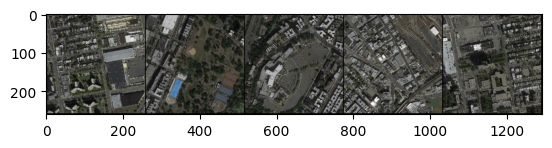

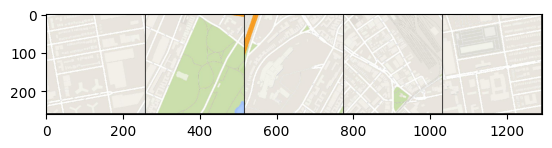

In [21]:
image, target = next(iter(dataloader_train))

Normalization_Values = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def DeNormalize(tensor_of_image):
  return tensor_of_image * Normalization_Values[1][0] + Normalization_Values[0][0]

# def print_image( image_tensor,):
#     for  index, image in enumerate(image_tensor):
#           fig1 = plt.figure()
#           plt.imshow(DeNormalize(image).permute(1,2,0))
#           plt.show()
#           if index > 4:
#             break;

# print_image(image)
# print_image(target)

image = DeNormalize(image)
target = DeNormalize(target)
image_grid = make_grid(image[:5], nrow=5)
target_grid = make_grid(target[:5],nrow=5)
plt.imshow(image_grid.permute(1, 2, 0).squeeze())
plt.show() 
plt.imshow(target_grid.permute(1, 2, 0).squeeze())
plt.show()